In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from glob import glob
import cv2
from tqdm.auto import tqdm
import os

## Define the Hyperparameters


In [29]:
# for local
DATA_DIR='HW_data'
# for Colab
# DATA_DIR='./Omniglot'

train_data_path = os.path.join(DATA_DIR, "source/")
val_data_path = os.path.join(DATA_DIR, "target/")

batch_size = 32
val_batch_size = 20
epochs = 10
inner_lr = 0.02

n_way = 3
k_shot = 4
q_query = 1

input_shape = (28, 28, 1)
outer_lr = 0.001

## Visualize Data

In [30]:
# training v.s test Omniglot classes
source_classes = glob(DATA_DIR+'/source/*')
target_classes = glob(DATA_DIR+'/target/*')
print(f'字符種類 train: test = {len(source_classes)} : {len(target_classes)}')

字符種類 train: test = 300 : 110


In [31]:
# dataset 結構: images_background/語言/字符id
source_classes[:5]

['HW_data/source\\10059_Agaricus_bernardii',
 'HW_data/source\\10065_Agaricus_campestris',
 'HW_data/source\\10082_Agaricus_langei',
 'HW_data/source\\10106_Agaricus_dulcidulus',
 'HW_data/source\\10123_Agrocybe_dura']

HW_data/source\18858_Pleurocybella_porrigens\ABANI2017-9210167_rJlQTOjX9b.JPG (800, 800, 3)


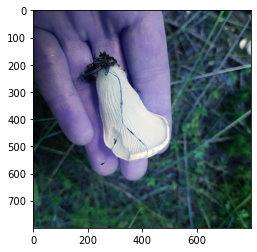

In [32]:
# 觀察圖片內容
path = np.random.choice(glob(DATA_DIR+'/source/*/*.JPG'), 1)[0]
img = cv2.imread(path)
print(path, img.shape)
plt.imshow(img)
plt.show()

## Prepare the data

In [33]:
class MetaDataLoader:
    def __init__(self, data_path, batch_size, n_way=5, k_shot=3, q_query=1):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = [f for f in glob(data_path + "*/", recursive=True)]
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = batch_size

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = cv2.resize(image, (227,227))
                image = np.expand_dims(image, axis=-1)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = cv2.resize(image, (227,227))
                image = np.expand_dims(image, axis=-1)
                query_image.append(image)
                query_label.append(label)

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

train_loader = MetaDataLoader(train_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)
val_loader = MetaDataLoader(val_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)

## Visualize some examples from the dataset


In [34]:
support_imgs, support_labels, q_imgs, q_labels = train_loader.get_one_task_data()

plt.figure(figsize=(20, 10))
for i in range(len(support_imgs)):
    plt.subplot(3, 5, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


## Build the model


In [17]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(padding='same')(x)
    return x


inputs = layers.Input(shape=(227, 227, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(n_way, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


inner_optimizer = keras.optimizers.Adam(learning_rate=inner_lr)
outer_optimizer = keras.optimizers.Adam(learning_rate=outer_lr)

model.compile(optimizer=inner_optimizer, 
              loss=keras.losses.sparse_categorical_crossentropy)

# AlexNet

In [35]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(n_way, activation='softmax')
])
inner_optimizer = keras.optimizers.Adam(learning_rate=inner_lr)
outer_optimizer = keras.optimizers.Adam(learning_rate=outer_lr)

model.compile(optimizer=inner_optimizer, 
              loss=keras.losses.sparse_categorical_crossentropy)
'''

## Train the model


In [37]:
def maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True):
    meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
    batch_acc = []
    batch_loss = []

    for support_image, support_label, query_image, query_label in zip(meta_support_image, meta_support_label, meta_query_image, meta_query_label):
        # 保存一開始model weights
        meta_weights = model.get_weights()

        # inner loop training
        for _ in range(inner_step):
            with tf.GradientTape() as tape:
                logits = model(support_image, training=True)
                loss = keras.losses.sparse_categorical_crossentropy(support_label, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            inner_optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # outer loop training: 計算query set loss
        with tf.GradientTape() as tape:
            logits = model(query_image, training=True)
            loss = keras.losses.sparse_categorical_crossentropy(query_label, logits)
            loss = tf.reduce_mean(loss)
            acc = (np.argmax(logits, -1) == query_label).astype(np.int32).mean()

            batch_loss.append(loss)
            batch_acc.append(acc)
        # 回復成一開始weights
        model.set_weights(meta_weights)

        # 在training set中需要更新 meta model
        if training:
            grads = tape.gradient(loss, model.trainable_variables)
            outer_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return np.array(batch_loss).mean(), np.array(batch_acc).mean()



#### MAML

In [38]:
train_meta_loss = []
train_meta_acc = []
val_meta_loss = []
val_meta_acc = []

for meta_iter in tqdm(range(epochs)):
    # Training
    for i in tqdm(range(train_loader.steps), leave=False):
        batch_data = train_loader.get_one_batch() # batch_sup_img, batch_sup_label, batch_query_img, batch_query_label
        batch_train_loss, batch_train_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)
        train_meta_loss.append(batch_train_loss)
        train_meta_acc.append(batch_train_acc)
    # Validation
    for i in range(val_loader.steps):
        batch_data = val_loader.get_one_batch()
        batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=3, training=False)
        val_meta_loss.append(batch_val_loss)
        val_meta_acc.append(batch_val_acc)
    print(f'[epoch {meta_iter:05d}]: train_loss: {np.mean(train_meta_loss):.4f} val_loss: {np.mean(val_meta_loss):.4f} train_acc: {np.mean(train_meta_acc):.3f} val_acc: {np.mean(val_meta_acc):.3f}')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00000]: train_loss: 10.7311 val_loss: 9.3337 train_acc: 0.333 val_acc: 0.372


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00001]: train_loss: 10.7383 val_loss: 9.8873 train_acc: 0.333 val_acc: 0.347


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00002]: train_loss: 10.7406 val_loss: 10.0870 train_acc: 0.333 val_acc: 0.341


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00003]: train_loss: 10.7418 val_loss: 10.1686 train_acc: 0.333 val_acc: 0.336


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00004]: train_loss: 10.7425 val_loss: 10.1192 train_acc: 0.333 val_acc: 0.341


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00005]: train_loss: 10.7430 val_loss: 10.1574 train_acc: 0.333 val_acc: 0.341


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00006]: train_loss: 10.7434 val_loss: 10.1641 train_acc: 0.333 val_acc: 0.342


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00007]: train_loss: 10.4077 val_loss: 10.0113 train_acc: 0.337 val_acc: 0.339


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00008]: train_loss: 10.1304 val_loss: 9.8351 train_acc: 0.336 val_acc: 0.339


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00009]: train_loss: 9.9005 val_loss: 9.7009 train_acc: 0.337 val_acc: 0.339


#### HINT: Generate Kaggle submission

In [39]:
class MetaDataLoader_test:
    def __init__(self, query_list, batch_size, n_way=5, k_shot=3, q_query=1):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = query_list
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = 1

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = cv2.resize(image, (227,227))
                image = np.expand_dims(image, axis=-1)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = cv2.resize(image, (227,227))
                image = np.expand_dims(image, axis=-1)
                query_image.append(image)
                query_label.append(label)

        # shuffle support set
        #random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        #random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

In [40]:
import pandas as pd
dt_test = pd.read_csv('test1.csv')
w = model.get_weights()


In [ ]:
f_ = []
y_ = []
for idx in dt_test.index:
    test_img = 'HW_data\\target_q\\' + dt_test.iloc[idx]['filename']
    f_.append(dt_test.iloc[idx]['filename'])
    
    data_test_path = ['HW_data\\target\\' + i for i in dt_test.iloc[idx].tolist()[1::]]
    test_loader = MetaDataLoader_test(data_test_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)
    model.set_weights(w)
    train_meta_loss = []
    train_meta_acc = []
    #'''
    for meta_iter in range(epochs):
        # Training
        batch_data = test_loader.get_one_batch()
        loss, acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)    
        train_meta_loss.append(loss)
        train_meta_acc.append(acc)
        print(f'[epoch {meta_iter:05d}]: train_loss: {np.mean(train_meta_loss):.4f}')
    #'''
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.
    img = cv2.resize(img, (227,227))
    img = np.expand_dims(img, axis=-1)
    img = np.array([img])
    y_pred = model.predict(img).argmax(axis=-1)
    print(int(y_pred))
    y_.append(int(y_pred))

[epoch 00000]: train_loss: 5.3728
[epoch 00001]: train_loss: 6.4393
[epoch 00002]: train_loss: 8.6608
[epoch 00003]: train_loss: 8.6260
[epoch 00004]: train_loss: 7.5904
[epoch 00005]: train_loss: 6.6526
[epoch 00006]: train_loss: 6.4698
[epoch 00007]: train_loss: 5.7974
[epoch 00008]: train_loss: 5.2884
[epoch 00009]: train_loss: 5.0985
0
[epoch 00000]: train_loss: 11.4960
[epoch 00001]: train_loss: 10.7009
[epoch 00002]: train_loss: 9.4322
[epoch 00003]: train_loss: 9.7258
[epoch 00004]: train_loss: 9.9297
[epoch 00005]: train_loss: 9.3583
[epoch 00006]: train_loss: 10.3240
[epoch 00007]: train_loss: 9.6355
[epoch 00008]: train_loss: 9.7395
[epoch 00009]: train_loss: 10.3773
0
[epoch 00000]: train_loss: 11.5903
[epoch 00001]: train_loss: 10.5020
[epoch 00002]: train_loss: 9.8167
[epoch 00003]: train_loss: 8.7057
[epoch 00004]: train_loss: 10.1882
[epoch 00005]: train_loss: 8.4907
[epoch 00006]: train_loss: 9.1514
[epoch 00007]: train_loss: 9.1243
[epoch 00008]: train_loss: 8.7142
[ep

[epoch 00009]: train_loss: 6.2171
0
[epoch 00000]: train_loss: 12.6656
[epoch 00001]: train_loss: 12.1375
[epoch 00002]: train_loss: 11.6791
[epoch 00003]: train_loss: 10.5444
[epoch 00004]: train_loss: 9.6147
[epoch 00005]: train_loss: 9.9114
[epoch 00006]: train_loss: 9.7426
[epoch 00007]: train_loss: 9.3016
[epoch 00008]: train_loss: 9.5577
[epoch 00009]: train_loss: 9.1392
0
[epoch 00000]: train_loss: 9.9512
[epoch 00001]: train_loss: 10.3483
[epoch 00002]: train_loss: 8.9422
[epoch 00003]: train_loss: 9.5489
[epoch 00004]: train_loss: 8.9199
[epoch 00005]: train_loss: 9.3972
[epoch 00006]: train_loss: 8.8222
[epoch 00007]: train_loss: 8.7627
[epoch 00008]: train_loss: 8.9830
[epoch 00009]: train_loss: 9.3832
0
[epoch 00000]: train_loss: 9.2120
[epoch 00001]: train_loss: 12.4147
[epoch 00002]: train_loss: 9.3275
[epoch 00003]: train_loss: 10.1840
[epoch 00004]: train_loss: 9.7596
[epoch 00005]: train_loss: 9.0673
[epoch 00006]: train_loss: 8.5419
[epoch 00007]: train_loss: 9.4889
[

[epoch 00008]: train_loss: 5.5230
[epoch 00009]: train_loss: 5.6128
0
[epoch 00000]: train_loss: 8.1963
[epoch 00001]: train_loss: 7.9671
[epoch 00002]: train_loss: 7.5969
[epoch 00003]: train_loss: 7.4251
[epoch 00004]: train_loss: 7.2650
[epoch 00005]: train_loss: 8.0668
[epoch 00006]: train_loss: 8.4831
[epoch 00007]: train_loss: 8.8571
[epoch 00008]: train_loss: 8.7827
[epoch 00009]: train_loss: 9.1340
0
[epoch 00000]: train_loss: 12.6063
[epoch 00001]: train_loss: 11.3078
[epoch 00002]: train_loss: 12.8387
[epoch 00003]: train_loss: 11.4777
[epoch 00004]: train_loss: 11.6242
[epoch 00005]: train_loss: 12.3732
[epoch 00006]: train_loss: 11.3731
[epoch 00007]: train_loss: 11.2947
[epoch 00008]: train_loss: 11.2336
[epoch 00009]: train_loss: 11.3075
0
[epoch 00000]: train_loss: 12.2030
[epoch 00001]: train_loss: 10.0475
[epoch 00002]: train_loss: 6.8053
[epoch 00003]: train_loss: 6.8251
[epoch 00004]: train_loss: 7.9952
[epoch 00005]: train_loss: 7.9790
[epoch 00006]: train_loss: 8.9

[epoch 00007]: train_loss: 7.9315
[epoch 00008]: train_loss: 7.6472
[epoch 00009]: train_loss: 7.9570
0
[epoch 00000]: train_loss: 8.2235
[epoch 00001]: train_loss: 9.9647
[epoch 00002]: train_loss: 12.0158
[epoch 00003]: train_loss: 11.6982
[epoch 00004]: train_loss: 11.6432
[epoch 00005]: train_loss: 9.7816
[epoch 00006]: train_loss: 9.9193
[epoch 00007]: train_loss: 9.7200
[epoch 00008]: train_loss: 9.8341
[epoch 00009]: train_loss: 9.6173
0
[epoch 00000]: train_loss: 11.5421
[epoch 00001]: train_loss: 7.3367
[epoch 00002]: train_loss: 8.4740
[epoch 00003]: train_loss: 9.9715
[epoch 00004]: train_loss: 9.1907
[epoch 00005]: train_loss: 9.6295
[epoch 00006]: train_loss: 9.7890
[epoch 00007]: train_loss: 9.2370
[epoch 00008]: train_loss: 8.2133
[epoch 00009]: train_loss: 7.6652
0
[epoch 00000]: train_loss: 2.2569
[epoch 00001]: train_loss: 1.7397
[epoch 00002]: train_loss: 2.9594
[epoch 00003]: train_loss: 5.5120
[epoch 00004]: train_loss: 6.4439
[epoch 00005]: train_loss: 7.0096
[epo

[epoch 00006]: train_loss: 8.3171
[epoch 00007]: train_loss: 8.3732
[epoch 00008]: train_loss: 8.3253
[epoch 00009]: train_loss: 7.4928
0
[epoch 00000]: train_loss: 5.3727
[epoch 00001]: train_loss: 6.8089
[epoch 00002]: train_loss: 6.3302
[epoch 00003]: train_loss: 6.4320
[epoch 00004]: train_loss: 7.2947
[epoch 00005]: train_loss: 6.9992
[epoch 00006]: train_loss: 7.5344
[epoch 00007]: train_loss: 7.0382
[epoch 00008]: train_loss: 7.2449
[epoch 00009]: train_loss: 7.5950
0
[epoch 00000]: train_loss: 0.7548
[epoch 00001]: train_loss: 4.8716
[epoch 00002]: train_loss: 5.2422
[epoch 00003]: train_loss: 5.0804
[epoch 00004]: train_loss: 5.1612
[epoch 00005]: train_loss: 5.1976
[epoch 00006]: train_loss: 6.4211
[epoch 00007]: train_loss: 6.7112
[epoch 00008]: train_loss: 5.9670
[epoch 00009]: train_loss: 5.6289
0
[epoch 00000]: train_loss: 10.3609
[epoch 00001]: train_loss: 10.2345
[epoch 00002]: train_loss: 8.9505
[epoch 00003]: train_loss: 8.3823
[epoch 00004]: train_loss: 7.3182
[epoch

[epoch 00005]: train_loss: 5.8494
[epoch 00006]: train_loss: 6.2213
[epoch 00007]: train_loss: 6.7868
[epoch 00008]: train_loss: 6.6493
[epoch 00009]: train_loss: 6.5826
0
[epoch 00000]: train_loss: 6.1604
[epoch 00001]: train_loss: 8.4530
[epoch 00002]: train_loss: 8.1529
[epoch 00003]: train_loss: 7.4648
[epoch 00004]: train_loss: 7.7975
[epoch 00005]: train_loss: 8.2071
[epoch 00006]: train_loss: 8.5697
[epoch 00007]: train_loss: 8.3038
[epoch 00008]: train_loss: 8.5751
[epoch 00009]: train_loss: 8.2549
0
[epoch 00000]: train_loss: 5.5264
[epoch 00001]: train_loss: 7.9979
[epoch 00002]: train_loss: 7.4579
[epoch 00003]: train_loss: 7.1769
[epoch 00004]: train_loss: 6.8162
[epoch 00005]: train_loss: 6.5347
[epoch 00006]: train_loss: 6.2009
[epoch 00007]: train_loss: 6.1155
[epoch 00008]: train_loss: 6.6299
[epoch 00009]: train_loss: 6.5050
0
[epoch 00000]: train_loss: 3.6438
[epoch 00001]: train_loss: 2.8049
[epoch 00002]: train_loss: 3.6616
[epoch 00003]: train_loss: 3.9114
[epoch 0

[epoch 00004]: train_loss: 10.5550
[epoch 00005]: train_loss: 11.4822
[epoch 00006]: train_loss: 12.1444
[epoch 00007]: train_loss: 11.5419
[epoch 00008]: train_loss: 10.9160
[epoch 00009]: train_loss: 10.2897
0
[epoch 00000]: train_loss: 7.2566
[epoch 00001]: train_loss: 9.0216
[epoch 00002]: train_loss: 9.3439
[epoch 00003]: train_loss: 9.9989
[epoch 00004]: train_loss: 10.6107
[epoch 00005]: train_loss: 10.0010
[epoch 00006]: train_loss: 10.2789
[epoch 00007]: train_loss: 11.0088
[epoch 00008]: train_loss: 10.5711
[epoch 00009]: train_loss: 10.0666
0
[epoch 00000]: train_loss: 6.1238
[epoch 00001]: train_loss: 5.9271
[epoch 00002]: train_loss: 5.7400
[epoch 00003]: train_loss: 6.6267
[epoch 00004]: train_loss: 5.3082
[epoch 00005]: train_loss: 6.3056
[epoch 00006]: train_loss: 5.4057
[epoch 00007]: train_loss: 6.2105
[epoch 00008]: train_loss: 6.1211
[epoch 00009]: train_loss: 5.5091
0
[epoch 00000]: train_loss: 5.1400
[epoch 00001]: train_loss: 9.7273
[epoch 00002]: train_loss: 7.4

[epoch 00003]: train_loss: 9.4800
[epoch 00004]: train_loss: 8.7396
[epoch 00005]: train_loss: 9.0771
[epoch 00006]: train_loss: 7.7804
[epoch 00007]: train_loss: 7.3154
[epoch 00008]: train_loss: 7.6966
[epoch 00009]: train_loss: 7.5006
0
[epoch 00000]: train_loss: 5.8109
[epoch 00001]: train_loss: 6.2056
[epoch 00002]: train_loss: 6.5343
[epoch 00003]: train_loss: 7.0144
[epoch 00004]: train_loss: 7.7606
[epoch 00005]: train_loss: 7.6614
[epoch 00006]: train_loss: 7.3345
[epoch 00007]: train_loss: 7.3827
[epoch 00008]: train_loss: 7.1703
[epoch 00009]: train_loss: 7.5353
0
[epoch 00000]: train_loss: 2.0740
[epoch 00001]: train_loss: 4.3430
[epoch 00002]: train_loss: 5.0808
[epoch 00003]: train_loss: 6.1072
[epoch 00004]: train_loss: 7.0348
[epoch 00005]: train_loss: 5.9218
[epoch 00006]: train_loss: 5.7104
[epoch 00007]: train_loss: 6.3398
[epoch 00008]: train_loss: 6.7305
[epoch 00009]: train_loss: 6.8494
0
[epoch 00000]: train_loss: 13.1422
[epoch 00001]: train_loss: 11.2130
[epoch

[epoch 00002]: train_loss: 6.4050
[epoch 00003]: train_loss: 5.2564
[epoch 00004]: train_loss: 5.0231
[epoch 00005]: train_loss: 6.1608
[epoch 00006]: train_loss: 6.2028
[epoch 00007]: train_loss: 6.2938
[epoch 00008]: train_loss: 6.9498
[epoch 00009]: train_loss: 6.6570
0
[epoch 00000]: train_loss: 10.7454
[epoch 00001]: train_loss: 8.4565
[epoch 00002]: train_loss: 6.6948
[epoch 00003]: train_loss: 6.3657
[epoch 00004]: train_loss: 7.2417
[epoch 00005]: train_loss: 8.3456
[epoch 00006]: train_loss: 8.1914
[epoch 00007]: train_loss: 8.5107
[epoch 00008]: train_loss: 9.2595
[epoch 00009]: train_loss: 8.9000
0
[epoch 00000]: train_loss: 10.7454
[epoch 00001]: train_loss: 9.1428
[epoch 00002]: train_loss: 9.2531
[epoch 00003]: train_loss: 10.1308
[epoch 00004]: train_loss: 9.1966
[epoch 00005]: train_loss: 9.4547
[epoch 00006]: train_loss: 8.8868
[epoch 00007]: train_loss: 8.0517
[epoch 00008]: train_loss: 7.9514
[epoch 00009]: train_loss: 8.7681
0
[epoch 00000]: train_loss: 10.7454
[epo

[epoch 00001]: train_loss: 4.2765
[epoch 00002]: train_loss: 6.8624
[epoch 00003]: train_loss: 7.6801
[epoch 00004]: train_loss: 7.9874
[epoch 00005]: train_loss: 7.5517
[epoch 00006]: train_loss: 6.8860
[epoch 00007]: train_loss: 7.0610
[epoch 00008]: train_loss: 7.0278
[epoch 00009]: train_loss: 6.3967
0
[epoch 00000]: train_loss: 14.7024
[epoch 00001]: train_loss: 11.3340
[epoch 00002]: train_loss: 7.5756
[epoch 00003]: train_loss: 7.0178
[epoch 00004]: train_loss: 7.8358
[epoch 00005]: train_loss: 6.5382
[epoch 00006]: train_loss: 7.1926
[epoch 00007]: train_loss: 6.2968
[epoch 00008]: train_loss: 6.7911
[epoch 00009]: train_loss: 7.5811
0
[epoch 00000]: train_loss: 0.0078
[epoch 00001]: train_loss: 4.5310
[epoch 00002]: train_loss: 7.7755
[epoch 00003]: train_loss: 8.5314
[epoch 00004]: train_loss: 8.1129
[epoch 00005]: train_loss: 7.1113
[epoch 00006]: train_loss: 7.6304
[epoch 00007]: train_loss: 7.3647
[epoch 00008]: train_loss: 7.2368
[epoch 00009]: train_loss: 7.5122
0
[epoch

0
[epoch 00000]: train_loss: 8.4535
[epoch 00001]: train_loss: 9.6004
[epoch 00002]: train_loss: 8.1912
[epoch 00003]: train_loss: 7.8183
[epoch 00004]: train_loss: 9.2071
[epoch 00005]: train_loss: 8.7888
[epoch 00006]: train_loss: 8.3584
[epoch 00007]: train_loss: 8.6571
[epoch 00008]: train_loss: 8.3382
[epoch 00009]: train_loss: 8.5837
0
[epoch 00000]: train_loss: 4.2551
[epoch 00001]: train_loss: 5.0784
[epoch 00002]: train_loss: 3.3856
[epoch 00003]: train_loss: 4.9672
[epoch 00004]: train_loss: 6.3847
[epoch 00005]: train_loss: 6.4166
[epoch 00006]: train_loss: 7.1580
[epoch 00007]: train_loss: 6.6367
[epoch 00008]: train_loss: 6.4867
[epoch 00009]: train_loss: 6.2337
0
[epoch 00000]: train_loss: 6.9455
[epoch 00001]: train_loss: 8.9860
[epoch 00002]: train_loss: 8.0040
[epoch 00003]: train_loss: 8.6894
[epoch 00004]: train_loss: 8.2737
[epoch 00005]: train_loss: 8.9388
[epoch 00006]: train_loss: 9.2021
[epoch 00007]: train_loss: 10.0666
[epoch 00008]: train_loss: 9.7541
[epoch 

[epoch 00009]: train_loss: 6.9766
0
[epoch 00000]: train_loss: 9.6348
[epoch 00001]: train_loss: 12.7320
[epoch 00002]: train_loss: 9.9050
[epoch 00003]: train_loss: 9.5047
[epoch 00004]: train_loss: 10.3077
[epoch 00005]: train_loss: 9.0613
[epoch 00006]: train_loss: 7.9634
[epoch 00007]: train_loss: 7.9007
[epoch 00008]: train_loss: 7.1780
[epoch 00009]: train_loss: 7.5347
0
[epoch 00000]: train_loss: 8.8850
[epoch 00001]: train_loss: 4.4434
[epoch 00002]: train_loss: 4.3085
[epoch 00003]: train_loss: 6.7291
[epoch 00004]: train_loss: 7.0384
[epoch 00005]: train_loss: 7.1336
[epoch 00006]: train_loss: 7.3748
[epoch 00007]: train_loss: 7.6282
[epoch 00008]: train_loss: 8.0650
[epoch 00009]: train_loss: 7.8510
0
[epoch 00000]: train_loss: 10.7454
[epoch 00001]: train_loss: 9.6816
[epoch 00002]: train_loss: 10.0423
[epoch 00003]: train_loss: 10.2369
[epoch 00004]: train_loss: 10.3397
[epoch 00005]: train_loss: 9.5222
[epoch 00006]: train_loss: 9.2176
[epoch 00007]: train_loss: 9.5295
[e

[epoch 00009]: train_loss: 7.2871
0
[epoch 00000]: train_loss: 10.1701
[epoch 00001]: train_loss: 5.7036
[epoch 00002]: train_loss: 7.4529
[epoch 00003]: train_loss: 8.0792
[epoch 00004]: train_loss: 7.6491
[epoch 00005]: train_loss: 7.3869
[epoch 00006]: train_loss: 7.4092
[epoch 00007]: train_loss: 8.0846
[epoch 00008]: train_loss: 8.1301
[epoch 00009]: train_loss: 8.5383
0
[epoch 00000]: train_loss: 1.9511
[epoch 00001]: train_loss: 5.7104
[epoch 00002]: train_loss: 7.7330
[epoch 00003]: train_loss: 7.1429
[epoch 00004]: train_loss: 8.8616
[epoch 00005]: train_loss: 8.9366
[epoch 00006]: train_loss: 9.1950
[epoch 00007]: train_loss: 8.8377
[epoch 00008]: train_loss: 8.4528
[epoch 00009]: train_loss: 8.2105
0
[epoch 00000]: train_loss: 10.0158
[epoch 00001]: train_loss: 8.1574
[epoch 00002]: train_loss: 7.1485
[epoch 00003]: train_loss: 6.7284
[epoch 00004]: train_loss: 6.4573
[epoch 00005]: train_loss: 7.6448
[epoch 00006]: train_loss: 7.3204
[epoch 00007]: train_loss: 8.3293
[epoch

[epoch 00009]: train_loss: 7.9014
0
[epoch 00000]: train_loss: 4.1234
[epoch 00001]: train_loss: 5.6408
[epoch 00002]: train_loss: 5.0148
[epoch 00003]: train_loss: 5.1966
[epoch 00004]: train_loss: 5.4712
[epoch 00005]: train_loss: 6.1396
[epoch 00006]: train_loss: 6.7976
[epoch 00007]: train_loss: 5.9488
[epoch 00008]: train_loss: 6.1181
[epoch 00009]: train_loss: 6.3485
0
[epoch 00000]: train_loss: 2.1111
[epoch 00001]: train_loss: 8.4751
[epoch 00002]: train_loss: 9.6293
[epoch 00003]: train_loss: 9.2861
[epoch 00004]: train_loss: 10.6525
[epoch 00005]: train_loss: 9.7725
[epoch 00006]: train_loss: 8.5353
[epoch 00007]: train_loss: 9.4832
[epoch 00008]: train_loss: 9.6234
[epoch 00009]: train_loss: 9.6184
0
[epoch 00000]: train_loss: 7.6422
[epoch 00001]: train_loss: 6.7396
[epoch 00002]: train_loss: 4.9156
[epoch 00003]: train_loss: 6.3731
[epoch 00004]: train_loss: 7.1027
[epoch 00005]: train_loss: 7.7098
[epoch 00006]: train_loss: 7.4353
[epoch 00007]: train_loss: 7.7305
[epoch 

[epoch 00008]: train_loss: 8.1285
[epoch 00009]: train_loss: 8.6023
0
[epoch 00000]: train_loss: 3.4961
[epoch 00001]: train_loss: 8.1300
[epoch 00002]: train_loss: 9.1261
[epoch 00003]: train_loss: 9.5406
[epoch 00004]: train_loss: 10.6448
[epoch 00005]: train_loss: 9.7661
[epoch 00006]: train_loss: 9.9069
[epoch 00007]: train_loss: 10.4403
[epoch 00008]: train_loss: 10.4929
[epoch 00009]: train_loss: 10.5181
0
[epoch 00000]: train_loss: 10.7454
[epoch 00001]: train_loss: 10.7454
[epoch 00002]: train_loss: 10.7454
[epoch 00003]: train_loss: 10.5934
[epoch 00004]: train_loss: 10.6238
[epoch 00005]: train_loss: 10.8047
[epoch 00006]: train_loss: 10.0466
[epoch 00007]: train_loss: 10.1443
[epoch 00008]: train_loss: 10.2111
[epoch 00009]: train_loss: 9.9275
0
[epoch 00000]: train_loss: 15.1003
[epoch 00001]: train_loss: 14.5268
[epoch 00002]: train_loss: 15.0572
[epoch 00003]: train_loss: 13.7210
[epoch 00004]: train_loss: 12.9757
[epoch 00005]: train_loss: 13.4994
[epoch 00006]: train_lo

[epoch 00006]: train_loss: 8.2170
[epoch 00007]: train_loss: 8.3439
[epoch 00008]: train_loss: 9.2077
[epoch 00009]: train_loss: 9.3615
0
[epoch 00000]: train_loss: 8.1597
[epoch 00001]: train_loss: 6.7687
[epoch 00002]: train_loss: 4.5484
[epoch 00003]: train_loss: 6.7750
[epoch 00004]: train_loss: 6.7892
[epoch 00005]: train_loss: 7.4503
[epoch 00006]: train_loss: 8.6255
[epoch 00007]: train_loss: 8.7552
[epoch 00008]: train_loss: 8.7925
[epoch 00009]: train_loss: 8.3731
0
[epoch 00000]: train_loss: 10.6533
[epoch 00001]: train_loss: 8.0131
[epoch 00002]: train_loss: 7.1521
[epoch 00003]: train_loss: 6.7417
[epoch 00004]: train_loss: 6.6664
[epoch 00005]: train_loss: 6.6240
[epoch 00006]: train_loss: 7.5644
[epoch 00007]: train_loss: 6.7990
[epoch 00008]: train_loss: 6.8027
[epoch 00009]: train_loss: 7.1969
0
[epoch 00000]: train_loss: 3.2457
[epoch 00001]: train_loss: 4.3092
[epoch 00002]: train_loss: 5.8377
[epoch 00003]: train_loss: 5.7952
[epoch 00004]: train_loss: 6.7852
[epoch 

[epoch 00004]: train_loss: 11.0498
[epoch 00005]: train_loss: 11.0040
[epoch 00006]: train_loss: 11.0391
[epoch 00007]: train_loss: 10.9890
[epoch 00008]: train_loss: 10.2792
[epoch 00009]: train_loss: 10.3287
0
[epoch 00000]: train_loss: 6.0687
[epoch 00001]: train_loss: 6.3531
[epoch 00002]: train_loss: 6.4409
[epoch 00003]: train_loss: 6.1739
[epoch 00004]: train_loss: 5.5267
[epoch 00005]: train_loss: 4.8738
[epoch 00006]: train_loss: 5.4676
[epoch 00007]: train_loss: 5.6648
[epoch 00008]: train_loss: 6.1133
[epoch 00009]: train_loss: 5.5043
0
[epoch 00000]: train_loss: 10.7454
[epoch 00001]: train_loss: 11.5959
[epoch 00002]: train_loss: 12.3276
[epoch 00003]: train_loss: 10.6411
[epoch 00004]: train_loss: 9.8214
[epoch 00005]: train_loss: 9.9395
[epoch 00006]: train_loss: 9.4717
[epoch 00007]: train_loss: 8.5197
[epoch 00008]: train_loss: 8.8902
[epoch 00009]: train_loss: 9.6130
0
[epoch 00000]: train_loss: 0.8037
[epoch 00001]: train_loss: 3.5356
[epoch 00002]: train_loss: 5.305

[epoch 00002]: train_loss: 7.6519
[epoch 00003]: train_loss: 7.0821
[epoch 00004]: train_loss: 7.1834
[epoch 00005]: train_loss: 8.4798
[epoch 00006]: train_loss: 8.8074
[epoch 00007]: train_loss: 8.8626
[epoch 00008]: train_loss: 9.5889
[epoch 00009]: train_loss: 9.5590
0
[epoch 00000]: train_loss: 9.0388
[epoch 00001]: train_loss: 11.3360
[epoch 00002]: train_loss: 8.6944
[epoch 00003]: train_loss: 9.2071
[epoch 00004]: train_loss: 9.6174
[epoch 00005]: train_loss: 8.9101
[epoch 00006]: train_loss: 9.1723
[epoch 00007]: train_loss: 8.0562
[epoch 00008]: train_loss: 8.1981
[epoch 00009]: train_loss: 8.4534
0
[epoch 00000]: train_loss: 7.9721
[epoch 00001]: train_loss: 9.3588
[epoch 00002]: train_loss: 8.0301
[epoch 00003]: train_loss: 7.5288
[epoch 00004]: train_loss: 8.1093
[epoch 00005]: train_loss: 8.1661
[epoch 00006]: train_loss: 7.5547
[epoch 00007]: train_loss: 7.3707
[epoch 00008]: train_loss: 7.3593
[epoch 00009]: train_loss: 7.6979
0
[epoch 00000]: train_loss: 5.6936
[epoch 

[epoch 00001]: train_loss: 9.9497
[epoch 00002]: train_loss: 10.2149
[epoch 00003]: train_loss: 10.3476
[epoch 00004]: train_loss: 10.6183
[epoch 00005]: train_loss: 10.6395
[epoch 00006]: train_loss: 10.6546
[epoch 00007]: train_loss: 10.6659
[epoch 00008]: train_loss: 10.6748
[epoch 00009]: train_loss: 10.4958
0
[epoch 00000]: train_loss: 9.5496
[epoch 00001]: train_loss: 10.1475
[epoch 00002]: train_loss: 10.2689
[epoch 00003]: train_loss: 11.7312
[epoch 00004]: train_loss: 12.0479
[epoch 00005]: train_loss: 10.9534
[epoch 00006]: train_loss: 10.6569
[epoch 00007]: train_loss: 10.6471
[epoch 00008]: train_loss: 10.6581
[epoch 00009]: train_loss: 10.2901
0
[epoch 00000]: train_loss: 6.0682
[epoch 00001]: train_loss: 3.8846
[epoch 00002]: train_loss: 4.5774
[epoch 00003]: train_loss: 4.7764
[epoch 00004]: train_loss: 5.5746
[epoch 00005]: train_loss: 6.5039
[epoch 00006]: train_loss: 5.5748
[epoch 00007]: train_loss: 5.9994
[epoch 00008]: train_loss: 5.9299
[epoch 00009]: train_loss: 

[epoch 00009]: train_loss: 7.3527
0
[epoch 00000]: train_loss: 10.7463
[epoch 00001]: train_loss: 11.0471
[epoch 00002]: train_loss: 10.8224
[epoch 00003]: train_loss: 8.7224
[epoch 00004]: train_loss: 9.1270
[epoch 00005]: train_loss: 8.6080
[epoch 00006]: train_loss: 8.0134
[epoch 00007]: train_loss: 7.6895
[epoch 00008]: train_loss: 8.0291
[epoch 00009]: train_loss: 8.3007
0
[epoch 00000]: train_loss: 16.1181
[epoch 00001]: train_loss: 15.1023
[epoch 00002]: train_loss: 11.6296
[epoch 00003]: train_loss: 11.7880
[epoch 00004]: train_loss: 10.5479
[epoch 00005]: train_loss: 10.5267
[epoch 00006]: train_loss: 10.6854
[epoch 00007]: train_loss: 9.5987
[epoch 00008]: train_loss: 8.6973
[epoch 00009]: train_loss: 9.4394
0
[epoch 00000]: train_loss: 16.1181
[epoch 00001]: train_loss: 12.6481
[epoch 00002]: train_loss: 12.6051
[epoch 00003]: train_loss: 10.3030
[epoch 00004]: train_loss: 10.5777
[epoch 00005]: train_loss: 10.1244
[epoch 00006]: train_loss: 10.5390
[epoch 00007]: train_loss

[epoch 00008]: train_loss: 10.9640
[epoch 00009]: train_loss: 10.9421
0
[epoch 00000]: train_loss: 7.5182
[epoch 00001]: train_loss: 9.1318
[epoch 00002]: train_loss: 9.6697
[epoch 00003]: train_loss: 9.9386
[epoch 00004]: train_loss: 10.1000
[epoch 00005]: train_loss: 9.0657
[epoch 00006]: train_loss: 9.1985
[epoch 00007]: train_loss: 8.0498
[epoch 00008]: train_loss: 8.0835
[epoch 00009]: train_loss: 8.3535
0
[epoch 00000]: train_loss: 7.0317
[epoch 00001]: train_loss: 6.2024
[epoch 00002]: train_loss: 9.3871
[epoch 00003]: train_loss: 8.3772
[epoch 00004]: train_loss: 6.8580
[epoch 00005]: train_loss: 6.5430
[epoch 00006]: train_loss: 5.6555
[epoch 00007]: train_loss: 5.9200
[epoch 00008]: train_loss: 5.7215
[epoch 00009]: train_loss: 6.2499
0
[epoch 00000]: train_loss: 11.0641
[epoch 00001]: train_loss: 8.3631
[epoch 00002]: train_loss: 9.7186
[epoch 00003]: train_loss: 9.0065
[epoch 00004]: train_loss: 8.2797
[epoch 00005]: train_loss: 9.3093
[epoch 00006]: train_loss: 10.2820
[ep

[epoch 00008]: train_loss: 9.6605
[epoch 00009]: train_loss: 9.7690
0
[epoch 00000]: train_loss: 5.3846
[epoch 00001]: train_loss: 6.1305
[epoch 00002]: train_loss: 7.9167
[epoch 00003]: train_loss: 8.5162
[epoch 00004]: train_loss: 8.9621
[epoch 00005]: train_loss: 9.2593
[epoch 00006]: train_loss: 9.4716
[epoch 00007]: train_loss: 9.6308
[epoch 00008]: train_loss: 9.7547
[epoch 00009]: train_loss: 9.6826
0
[epoch 00000]: train_loss: 8.7320
[epoch 00001]: train_loss: 7.0525
[epoch 00002]: train_loss: 8.2835
[epoch 00003]: train_loss: 8.8991
[epoch 00004]: train_loss: 8.1939
[epoch 00005]: train_loss: 8.6192
[epoch 00006]: train_loss: 8.9238
[epoch 00007]: train_loss: 9.1515
[epoch 00008]: train_loss: 9.9256
[epoch 00009]: train_loss: 10.0076
0
[epoch 00000]: train_loss: 7.1590
[epoch 00001]: train_loss: 11.6385
[epoch 00002]: train_loss: 11.3408
[epoch 00003]: train_loss: 9.1445
[epoch 00004]: train_loss: 10.4815
[epoch 00005]: train_loss: 10.5255
[epoch 00006]: train_loss: 10.7395
[e